# Model Pipeline

In this notebook we'll go through the steps we need to take to load labelled data and train a model to predict a label based on text input. We'll start off with a simple model using Support Vector Machines (SVMs), before exploring how we would do this using by fine-tuning a language model using [transformers](https://huggingface.co/docs/transformers/index) 🤗

## Data

We'll start by loading our labels and merging these with the studies we downloaded from OpenAlex

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import re
labelled_data = pd.read_csv('data/0_labelled_documents.csv')

impacts = [x for x in labelled_data.columns if re.match("^12 -",x)]
labelled_data = labelled_data[["id","content","title","seen","INCLUDE"] + impacts]
labelled_data = labelled_data.drop(columns="12 - Physical systems")
impacts = [x for x in labelled_data.columns if re.match("^12 -",x)]
labelled_data = labelled_data.rename(columns={"content": "abstract"})
labelled_data = labelled_data.drop(labelled_data[(labelled_data["INCLUDE"]==1) & (labelled_data[impacts].sum(axis=1)==0)].index)
labelled_data.to_csv('data/labelled_data.csv', index=False)


In [3]:
labelled_data = pd.read_csv("data/labelled_data.csv")

# We create a lower case version of the title without spaces and punctuation, to allow for merging
labelled_data["title_lcase"] = labelled_data["title"].apply(lambda x: re.sub("\W","",x).lower())
# We also want to get rid of documents without abstracts, as we can't use these for learning
labelled_data = labelled_data.dropna(subset=["abstract"])
print(labelled_data.shape)
labelled_data.head()

(2500, 11)


,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,title_lcase
0,1448689,"The city of Bismarck, North Dakota has one of ...",Key Factors Influencing the Incidence of West ...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,keyfactorsinfluencingtheincidenceofwestnilevir...
1,3281128,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,asymmetricresponsesofplantcommunitystructurean...
2,900708,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,climateeffectsonfireregimesandtreerecruitmenti...
3,3234419,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,climatechangeadaptationandmitigationahitherton...
4,2090028,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,caribbeanmangrovesadjusttorisingsealevelthroug...


In [4]:
# Now we load the Open alex data, and create the same title variable for merging

oa_data = pd.read_csv("data/openalex_data.csv").rename(columns={"id": "OA_id"})
oa_data["title_lcase"] = oa_data["title"].apply(lambda x: re.sub("\W","",x).lower())
oa_data = oa_data.dropna(subset=["abstract"])
oa_data["seen"] = 0
print(oa_data.shape)
oa_data.head()

(8113, 8)


,OA_id,doi,title,publication_year,abstract,authors,title_lcase,seen
0,https://openalex.org/W2076977109,https://doi.org/10.1038/nature03906,Increasing destructiveness of tropical cyclone...,2005,Theory and modelling predict that hurricane in...,Kerry Emanuel,increasingdestructivenessoftropicalcyclonesove...,0
1,https://openalex.org/W2171979944,https://doi.org/10.1007/s00425-003-1105-5,"Plant responses to drought, salinity and extre...",2003,"Abiotic stresses, such as drought, salinity, e...","Wangxia Wang, Basia Vinocur, Arie Altman",plantresponsestodroughtsalinityandextremetempe...,0
2,https://openalex.org/W2122582889,https://doi.org/10.1073/pnas.0505734102,Regional vegetation die-off in response to glo...,2005,Future drought is projected to occur under war...,"David D. Breshears, Neil S. Cobb, Paul M. Rich...",regionalvegetationdieoffinresponsetoglobalchan...,0
3,https://openalex.org/W2101875448,NaN,INTRODUCED SPECIES: A SIGNIFICANT COMPONENT OF...,1997,Humans move species beyond their native ranges...,"Peter M. Vitousek, Carla M. D'Antonio, Lloyd L...",introducedspeciesasignificantcomponentofhumanc...,0
4,https://openalex.org/W2161828152,https://doi.org/10.1073/pnas.0901438106,Temperature sensitivity of drought-induced tre...,2009,Large-scale biogeographical shifts in vegetati...,"Henry D. Adams, Maite Guardiola-Claramonte, Gr...",temperaturesensitivityofdroughtinducedtreemort...,0


In [5]:
# Now we add the OpenAlex rows which are not in the labelled data to the labelled_data
df = pd.concat([
    labelled_data, 
    oa_data[~oa_data['title_lcase'].isin(labelled_data['title_lcase'])]
])
print(df.shape)
df.head()

(10539, 15)


,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,title_lcase,OA_id,doi,publication_year,authors
0,1448689.0,"The city of Bismarck, North Dakota has one of ...",Key Factors Influencing the Incidence of West ...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,keyfactorsinfluencingtheincidenceofwestnilevir...,NaN,NaN,NaN,NaN
1,3281128.0,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,asymmetricresponsesofplantcommunitystructurean...,NaN,NaN,NaN,NaN
2,900708.0,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,climateeffectsonfireregimesandtreerecruitmenti...,NaN,NaN,NaN,NaN
3,3234419.0,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,climatechangeadaptationandmitigationahitherton...,NaN,NaN,NaN,NaN
4,2090028.0,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,caribbeanmangrovesadjusttorisingsealevelthroug...,NaN,NaN,NaN,NaN


### Inspecting our labels

We can take a quick look at how many of which type of labels we have

<AxesSubplot:xlabel='seen'>

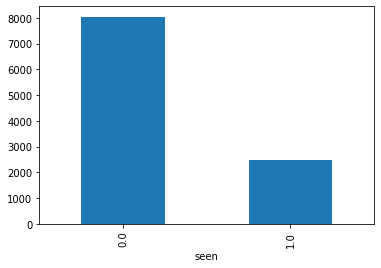

In [6]:
# We can quickly plot how many documents have been labelled, and how many not
df.groupby("seen")["title"].count().plot.bar()

<AxesSubplot:xlabel='INCLUDE'>

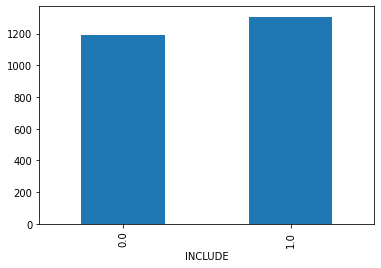

In [7]:
# and also plot how many of the labelled docs were included
df.groupby("INCLUDE")["title"].count().plot.bar()

<AxesSubplot:>

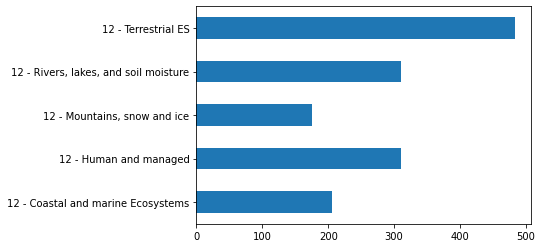

In [8]:
# Finally we can plot how many examples of each impact type we have

impacts = [x for x in df.columns if re.match("12 -",x)]
df[impacts].sum().plot.barh()

## A pipeline for a simple machine learning model

Now we want to put together a pipeline for a simple machine learning model. We'll start off by trying to predict the binary INCLUSION label, then move onto the impact type, which is a **multilabel** output. This means each document can be labelled with one or more of the impact types. 

In each case, though, the first thing we need to do is to encode our text input numerically, so it can be used in our models. To do this, we'll take a look at approaches from the feature extraction module from [scikitlearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text): `CountVectorizer` and `TfidfVectorizer`.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.porter import PorterStemmer

# Let's take for now a couple of example texts
texts = [
    "Climate change is impacting human systems",
    "Climate change is caused by fossil fuels",
    "System change not climate change"
]

# We'll instantiate a vectorizer class
vectorizer = CountVectorizer()

# And apply the fit_transform method to our texts
X = vectorizer.fit_transform(texts)

# This gives us a matrix of shape n_texts, vocab_size
X.todense()

matrix([[0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0]])

[[0 0 1 1 0 0 1 1 1 0 0 1]
 [1 1 1 1 1 1 0 0 1 0 0 0]
 [0 0 2 1 0 0 0 0 0 1 1 0]]


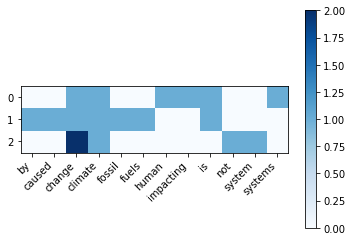

In [10]:
# The features each column represents can be accessed here
features = vectorizer.get_feature_names_out()

def visualize_doc_vec(X, features=None):
    print(X.todense())
    # And we could visualise this simply like this
    fig, ax = plt.subplots()
    doc_map = ax.imshow(X.todense(), cmap="Blues")
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=45, ha="right")
    cbar = fig.colorbar(doc_map)
    
visualize_doc_vec(X, features)

plt.show()

As we can see, each document is a row, each column is a feature. The cells contain the number of times each word occurs in each document. 

However, by adding a small amount of complexity we can generate a more useful way of representing these texts. EXPLAIN TFIDF HERE

[[0.         0.         0.28561676 0.28561676 0.         0.
  0.48359121 0.48359121 0.36778358 0.         0.         0.48359121]
 [0.43535684 0.43535684 0.25712876 0.25712876 0.43535684 0.43535684
  0.         0.         0.3311001  0.         0.         0.        ]
 [0.         0.         0.61046311 0.30523155 0.         0.
  0.         0.         0.         0.51680194 0.51680194 0.        ]]


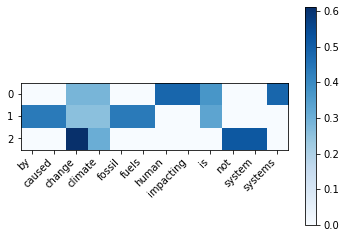

In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

features = vectorizer.get_feature_names_out()

visualize_doc_vec(X, features)

plt.show()

## Learning from features
Support Vector machines work by ...

In [12]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

clf = Pipeline(steps=[
    ("vect", TfidfVectorizer()), 
    ("clf", SVC(probability=True, class_weight="balanced"))
])

# We'll slightly expand our list of texts
texts, y = zip(*[
    ("Climate change is impacting human systems", 1),
    ("Climate change is caused by fossil fuels", 0),
    ("Agricultural yields are affected by climate change", 1),
    ("System change not climate change", 0),
    ("higher temperatures are impacting human health", 1),
    ("Forest fires are becoming more frequent due to climate change", 1),
    ("Machine learning can read texts", 0),
    ("AI can help solve climate change!", 0),
    ("We need to save gas this winter", 0),
    ("More frequent droughts are impacting crop yields", 1),
    ("Many communities are affected by rising sea levels", 1),
    ("Global emissions continue to rise", 0),
    ("Ecosystems are increasingly impacted by rising temperatures", 1),
    ("Emissions from fossil fuels need to decline", 0),
    ("Anthropogenic climate change is impacting vulnerable communities", 1)
])

clf.fit(texts,y)

Pipeline(steps=[('vec', TfidfVectorizer()),
                ('clf', SVC(class_weight='balanced', probability=True))])

In [13]:
# We can now use this classifier to make predictions about new texts

# Here are a couple of easy examples (easy because they are similar to our examples)
new_texts = [
    "climate change is impacting terrestrial ecosystems",
    "Machine Learning will solve climate change",
    "Fossil fuels are responsible for rising temperature"
]
# We can make predictions about which class the examples belong to
clf.predict(new_texts)

array([1, 0, 0])

In [14]:
# We can also get these as probabilities (which are very unstable with small datasets, and not guaranteed to match the predictions)
clf.predict_proba(new_texts)

array([[0.63550719, 0.36449281],
       [0.24950498, 0.75049502],
       [0.39217643, 0.60782357]])

In [15]:
# Each row contains predicted probabilites for each class, in this case 0, and 1

# We can get predicted probabilities of being in the INCLUDE class like this
clf.predict_proba(new_texts)[:,1]

array([0.36449281, 0.75049502, 0.60782357])

## Multilabel

Multilabel problems are those where any sample can belong to any of the classes (as opposed to multilaclass problems where each sample must belong to **exactly 1** class. In our dataset, most documents which were marked as relevant are assigned to one class, with some assigned to two, and very few assigned to three.

(array([1207.,    0.,    0.,    0.,    0.,   93.,    0.,    0.,    0.,
           6.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

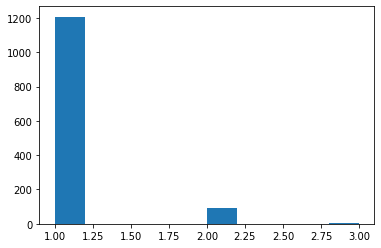

In [21]:
plt.hist(df[df["INCLUDE"]==1][impacts].sum(axis=1))

In [31]:
samples

Int64Index([1594,   39, 1110,  183, 1412, 1751, 2288, 1614, 2142, 1443, 2267,
            2164,  368,  284,  462,  783, 2060,  458, 1702, 1851,  382,    5,
            2027,   96, 2147,  276,  305, 1346, 2015, 1072, 1133,  199, 1149,
            2339, 2118,  696, 1329, 1613,  971, 1160,  678, 1198,   42, 1634,
             911, 2167, 1617,  493, 1311, 1079, 1806, 1210,  967,  188,  572,
              83, 2057, 2226,  620, 2059,  355,  974, 1105, 1884,  605, 1832,
            2155,  688,  777, 1833,  482,  167,  670,  807, 1662, 1017, 2191,
              80, 1704, 1465, 1434, 1248, 2393, 1126,  195, 1344, 1275,  224,
            1524,  890, 1572,  726, 1823,  902, 1843, 1186, 1914,  344, 2245,
            2035],
           dtype='int64')

,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES
1594,0.0,0.0,0.0,0.0,1.0
39,0.0,0.0,0.0,1.0,0.0
1110,1.0,0.0,0.0,0.0,0.0
183,1.0,0.0,0.0,0.0,0.0
1412,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
1186,0.0,0.0,0.0,1.0,0.0
1914,0.0,0.0,0.0,0.0,1.0
344,0.0,0.0,0.0,1.0,0.0
2245,1.0,0.0,0.0,0.0,0.0


To prepare our target for the model, we simply create a matrix with a row for each document and a column for each class

In [54]:


# create an x and y variable with a sample of 200 relevant documents
samples = df[df["INCLUDE"]==1].sample(200).index
X = df.iloc[samples]["abstract"]
y = df.iloc[samples][impacts].values
np.set_printoptions(threshold=5)
y

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

Now we just need to slightly amend our pipeline by defining how we want to approach the multilabel problem.

We use a One vs Rest classifier which simply creates a binary classifier for each class

In [55]:
from sklearn.multiclass import OneVsRestClassifier

clf = Pipeline(steps=[
    ("vec", TfidfVectorizer()), 
    ("clf", OneVsRestClassifier(SVC(probability=True, class_weight="balanced")))
])

clf.fit(X,y)

Pipeline(steps=[('vec', TfidfVectorizer()),
                ('clf',
                 OneVsRestClassifier(estimator=SVC(class_weight='balanced',
                                                   probability=True)))])

In [ ]:
# In the same way, we can make predictions

In [63]:
example_texts = [
    "Climate change has affected butterfly phenology in North America. "
    + "In an experiment in the butterfly national park, we found that "
    + "mean dates of appearance had shifted by two weeks. Species traits, "
    + "especially ecological traits, were found to explain some part of "
    + "different phenological responses",
    "Rising temperatures have contributed to increasing heat related mortaility "
    + "in cities across Europe. "
]
y_pred = clf.predict(example_texts)

pd.DataFrame(y_pred, columns=impacts)

,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES
0,0,0,0,0,1
1,0,1,0,0,0
